# User Story Ambiguity Detection using LLM

This notebook analyzes user stories to detect ambiguities using large language models (LLM).

## 1. Setup and Configuration

In [34]:
import pandas as pd
import numpy as np
import json
import re
from typing import Dict, List
from openai import OpenAI
import warnings
warnings.filterwarnings('ignore')

# Configuration
CONFIG = {
    "base_url": "https://api.zhizengzeng.com/v1/",
    "api_key": "sk-zk20f741becece1c055c848225093b2e458662329a0f1016"
}

# Models to test
MODELS = [
    "gpt-3.5-turbo",
    "deepseek-chat",
]

# Ambiguity types we're interested in
AMBIGUITY_TYPES = [
    'SemanticAmbiguity',
    'ScopeAmbiguity', 
    'ActorAmbiguity',
    'DependencyAmbiguity',
    'PriorityAmbiguity'
]

print("Configuration loaded successfully!")
print(f"Models to test: {MODELS}")
print(f"Ambiguity types: {AMBIGUITY_TYPES}")

Configuration loaded successfully!
Models to test: ['gpt-3.5-turbo', 'deepseek-chat']
Ambiguity types: ['SemanticAmbiguity', 'ScopeAmbiguity', 'ActorAmbiguity', 'DependencyAmbiguity', 'PriorityAmbiguity']


## 2. Load Dataset

In [35]:
# Load the Excel file
file_path = r"data\User Story Ambiguity Dataset_A Comprehensive Research Resource\Cornelius_2025_user_story_ambiguity_dataset.xlsx"
df = pd.read_excel(file_path)

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df[['StoryID', 'StoryText', 'HasAmbiguity'] + AMBIGUITY_TYPES].head())

Dataset loaded: 12847 rows, 24 columns

Columns: ['StoryID', 'CompanyID', 'ProjectID', 'StoryText', 'WordCount', 'CreationDate', 'Domain', 'CompanySize', 'AgileExperience', 'TeamSize', 'HasAmbiguity', 'AmbiguityCount', 'SemanticAmbiguity', 'ScopeAmbiguity', 'ActorAmbiguity', 'AcceptanceAmbiguity', 'DependencyAmbiguity', 'PriorityAmbiguity', 'TechnicalAmbiguity', 'DefectCount', 'DevelopmentTime', 'StoryPoints', 'CustomerSatisfaction', 'CompletionStatus']

First few rows:
     StoryID                                          StoryText  HasAmbiguity  \
0  US-C1-001  As a loan officer, I want to process applicati...          True   
1  US-C1-002  As a customer, I want to process application i...          True   
2  US-C1-003  As a user, I would like to view account balanc...          True   
3  US-C1-004  As a financial advisor, I want to access syste...          True   
4  US-C1-005  As a investor, I want to manage account so tha...          True   

   SemanticAmbiguity  ScopeAmbiguity  

## 3. LLM Prompts and Utility Functions

In [36]:
# System prompt for ambiguity detection
SYSTEM_PROMPT = """You are an expert in analyzing user stories for ambiguities. 
Your task is to:
1. Determine if a user story contains any ambiguity
2. If ambiguities exist, identify their specific types

Classification should return a JSON object with the following structure:
{
  "has_ambiguity": boolean,
  "ambiguity_types": [list of detected types],
  "explanation": "brief explanation of detected ambiguities"
}

Valid ambiguity types are:
- SemanticAmbiguity: Vague verbs or unclear meanings (e.g., 'manage', 'handle')
- ScopeAmbiguity: Unclear scope, boundaries, or completeness criteria
- ActorAmbiguity: Generic user roles without clear specification
- DependencyAmbiguity: Unclear external system dependencies or integrations
- PriorityAmbiguity: No clear priority or urgency specified

Be conservative in detecting ambiguities - only flag clear issues."""

def create_analysis_prompt(story_text: str) -> str:
    """Create a prompt for analyzing a single user story."""
    return f"""Analyze the following user story for ambiguities:

User Story: {story_text}

Provide your analysis as a JSON object with:
- has_ambiguity: true/false
- ambiguity_types: array of detected types (or empty array if no ambiguity)
- explanation: brief explanation

Return only the JSON object, no additional text."""

def call_llm(prompt: str, model: str) -> Dict:
    """
    Call the LLM API using OpenAI package.
    """
    try:
        client = OpenAI(api_key=CONFIG["api_key"], base_url=CONFIG["base_url"])
        
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": prompt}
            ],
            temperature=0.1
        )
        
        content = response.choices[0].message.content
        
        # Try to parse JSON response
        match = re.search(r'\{.*\}', content, re.DOTALL)
        if match:
            json_str = match.group()
            parsed_result = json.loads(json_str)
            return parsed_result
        else:
            return {
                "has_ambiguity": False,
                "ambiguity_types": [],
                "explanation": "Could not parse response"
            }
    except Exception as e:
        print(f"API call failed ({model}): {str(e)}")
        return {
            "has_ambiguity": False,
            "ambiguity_types": [],
            "explanation": f"API Error: {str(e)}"
        }

print("LLM utility functions loaded!")

LLM utility functions loaded!


## 4. Sample Analysis (First 100 Stories)

In [37]:
# Balanced sampling: 50 samples per ambiguity type (stratified, no overlap)
samples_per_type = 50

print(f"Performing stratified balanced sampling: {samples_per_type} samples per ambiguity type")
print(f"\nSampling strategy: No overlap - each story belongs to only one primary type\n")

# Step 1: Create a helper column to assign primary ambiguity type to each story
def get_primary_ambiguity_type(row):
    """Determine the primary ambiguity type for a story"""
    types = [col for col in AMBIGUITY_TYPES if row[col]]
    if not types:
        return 'No Ambiguity'
    # If multiple types, prioritize in this order (rarest types first)
    priority = ['PriorityAmbiguity', 'DependencyAmbiguity', 'ActorAmbiguity', 'ScopeAmbiguity', 'SemanticAmbiguity']
    for p in priority:
        if p in types:
            return p
    return types[0]

# Add primary type column
df['Primary_Type'] = df.apply(get_primary_ambiguity_type, axis=1)

print("Distribution by primary type:")
print(df['Primary_Type'].value_counts())
print()

# Step 2: For each ambiguity type, sample 50 stories where it is the primary type
sample_list = []
sampling_stats = {}

for ambiguity_type in AMBIGUITY_TYPES:
    # Get stories where this is the primary type
    primary_indices = df[df['Primary_Type'] == ambiguity_type].index.tolist()
    
    # Randomly sample up to samples_per_type
    if len(primary_indices) >= samples_per_type:
        sampled = np.random.choice(primary_indices, size=samples_per_type, replace=False)
        actual_sampled = samples_per_type
    else:
        sampled = primary_indices
        actual_sampled = len(sampled)
    
    sample_list.extend(sampled)
    sampling_stats[ambiguity_type] = {
        'sampled': actual_sampled,
        'available': len(primary_indices)
    }
    
    print(f"  {ambiguity_type}: sampled {actual_sampled} stories (available: {len(primary_indices)})")

# Create balanced sample dataframe
sample_df = df.loc[sample_list].copy()

print(f"\n{'='*70}")
print(f"Total unique stories sampled: {len(sample_df)}")
print(f"{'='*70}\n")

print(f"Ground truth distribution:")
print(sample_df['HasAmbiguity'].value_counts())
print(f"\nAmbiguity types distribution:")
for col in AMBIGUITY_TYPES:
    count = sample_df[col].sum()
    print(f"  {col}: {count}")
print(f"\nPrimary type distribution:")
print(sample_df['Primary_Type'].value_counts())

Performing stratified balanced sampling: 50 samples per ambiguity type

Sampling strategy: No overlap - each story belongs to only one primary type

Distribution by primary type:
Primary_Type
No Ambiguity           8677
SemanticAmbiguity      2076
ScopeAmbiguity          990
ActorAmbiguity          807
DependencyAmbiguity     187
PriorityAmbiguity       110
Name: count, dtype: int64

  SemanticAmbiguity: sampled 50 stories (available: 2076)
  ScopeAmbiguity: sampled 50 stories (available: 990)
  ActorAmbiguity: sampled 50 stories (available: 807)
  DependencyAmbiguity: sampled 50 stories (available: 187)
  PriorityAmbiguity: sampled 50 stories (available: 110)

Total unique stories sampled: 250

Ground truth distribution:
HasAmbiguity
True    250
Name: count, dtype: int64

Ambiguity types distribution:
  SemanticAmbiguity: 116
  ScopeAmbiguity: 87
  ActorAmbiguity: 71
  DependencyAmbiguity: 52
  PriorityAmbiguity: 50

Primary type distribution:
Primary_Type
SemanticAmbiguity      50
Sc

## 5. LLM Analysis (using gpt-3.5-turbo)

In [26]:
# Iterate through all models
all_results = []

for model in MODELS:
    print(f"\n{'='*80}")
    print(f"Analyzing with model: {model}")
    print(f"{'='*80}")
    print(f"Total stories to analyze: {len(sample_df)}")
    print("This may take a few minutes...\n")
    
    # Prepare results storage for this model
    results = []
    
    # Analyze each story
    for idx, (row_idx, row) in enumerate(sample_df.iterrows()):
        story_text = row['StoryText']
        story_id = row['StoryID']
        
        # Get ground truth
        ground_truth_ambiguity = row['HasAmbiguity']
        ground_truth_types = [col for col in AMBIGUITY_TYPES if row[col]]
        
        # Call LLM
        prompt = create_analysis_prompt(story_text)
        llm_result = call_llm(prompt, model)
        
        # Store result
        results.append({
            'StoryID': story_id,
            'StoryText': story_text,
            'Primary_Type': row.get('Primary_Type', 'Unknown'),
            'Ground_Truth_HasAmbiguity': ground_truth_ambiguity,
            'Ground_Truth_Types': ground_truth_types,
            'LLM_HasAmbiguity': llm_result.get('has_ambiguity', False),
            'LLM_Types': llm_result.get('ambiguity_types', []),
            'LLM_Explanation': llm_result.get('explanation', ''),
            'Model': model
        })
        
        # Print progress
        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx + 1}/{len(sample_df)} stories...")
    
    # Convert to DataFrame and add to all results
    model_results_df = pd.DataFrame(results)
    all_results.append(model_results_df)
    
    print(f"\n  ✓ Completed {model}")
    print(f"  Results: {len(model_results_df)} rows")

# Combine results from all models
results_df = pd.concat(all_results, ignore_index=True)

print(f"\n{'='*80}")
print(f"ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"Total analysis results: {len(results_df)} rows")
print(f"Models analyzed: {len(MODELS)}")
print(f"Results per model: {len(results_df) // len(MODELS)}")


Analyzing with model: gpt-3.5-turbo
Total stories to analyze: 250
This may take a few minutes...

  Processed 50/250 stories...
  Processed 100/250 stories...
  Processed 150/250 stories...
  Processed 200/250 stories...
  Processed 250/250 stories...

  ✓ Completed gpt-3.5-turbo
  Results: 250 rows

Analyzing with model: deepseek-chat
Total stories to analyze: 250
This may take a few minutes...

  Processed 50/250 stories...
  Processed 100/250 stories...
  Processed 150/250 stories...
  Processed 200/250 stories...
  Processed 250/250 stories...

  ✓ Completed deepseek-chat
  Results: 250 rows

ANALYSIS COMPLETE
Total analysis results: 500 rows
Models analyzed: 2
Results per model: 250


## 6. Evaluation - Ambiguity Detection (Has Ambiguity: Yes/No)

In [27]:
# Calculate metrics for ambiguity detection - for each model
model_evaluation_results = {}

print("="*80)
print("AMBIGUITY DETECTION EVALUATION (Has Ambiguity: Yes/No)")
print("="*80)

for model in MODELS:
    model_data = results_df[results_df['Model'] == model]
    
    tp = ((model_data['Ground_Truth_HasAmbiguity'] == True) & (model_data['LLM_HasAmbiguity'] == True)).sum()
    tn = ((model_data['Ground_Truth_HasAmbiguity'] == False) & (model_data['LLM_HasAmbiguity'] == False)).sum()
    fp = ((model_data['Ground_Truth_HasAmbiguity'] == False) & (model_data['LLM_HasAmbiguity'] == True)).sum()
    fn = ((model_data['Ground_Truth_HasAmbiguity'] == True) & (model_data['LLM_HasAmbiguity'] == False)).sum()
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    model_evaluation_results[model] = {
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn,
        'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1
    }
    
    print(f"\nModel: {model}")
    print(f"-" * 80)
    print(f"Confusion Matrix:")
    print(f"  True Positives (TP):  {tp}")
    print(f"  True Negatives (TN):  {tn}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"Metrics:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1 Score:  {f1:.4f}")

print("="*80)

AMBIGUITY DETECTION EVALUATION (Has Ambiguity: Yes/No)

Model: gpt-3.5-turbo
--------------------------------------------------------------------------------
Confusion Matrix:
  True Positives (TP):  250
  True Negatives (TN):  0
  False Positives (FP): 0
  False Negatives (FN): 0
Metrics:
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000 (100.00%)
  Recall:    1.0000 (100.00%)
  F1 Score:  1.0000

Model: deepseek-chat
--------------------------------------------------------------------------------
Confusion Matrix:
  True Positives (TP):  250
  True Negatives (TN):  0
  False Positives (FP): 0
  False Negatives (FN): 0
Metrics:
  Accuracy:  1.0000 (100.00%)
  Precision: 1.0000 (100.00%)
  Recall:    1.0000 (100.00%)
  F1 Score:  1.0000


## 7. Evaluation - Ambiguity Type Classification

In [28]:
# Evaluate ambiguity type classification - for each model
type_metrics_all_models = {}

print("\n" + "="*80)
print("AMBIGUITY TYPE CLASSIFICATION EVALUATION")
print("="*80)

for model in MODELS:
    model_data = results_df[results_df['Model'] == model]
    
    print(f"\n\nModel: {model}")
    print(f"-" * 80)
    print(f"Per-Type Metrics:")
    print(f"{'Type':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
    print("-" * 80)
    
    type_metrics = {}
    
    for ambiguity_type in AMBIGUITY_TYPES:
        # For each type, check binary classification
        ground_truth_binary = model_data.apply(lambda x: ambiguity_type in x['Ground_Truth_Types'], axis=1)
        llm_binary = model_data.apply(lambda x: ambiguity_type in x['LLM_Types'], axis=1)
        
        # Calculate metrics
        tp = ((ground_truth_binary == True) & (llm_binary == True)).sum()
        tn = ((ground_truth_binary == False) & (llm_binary == False)).sum()
        fp = ((ground_truth_binary == False) & (llm_binary == True)).sum()
        fn = ((ground_truth_binary == True) & (llm_binary == False)).sum()
        
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        type_metrics[ambiguity_type] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn
        }
        
        print(f"{ambiguity_type:<25} {accuracy:<12.4f} {precision:<12.4f} {recall:<12.4f} {f1:<12.4f}")
    
    print("-" * 80)
    
    # Macro-average
    macro_accuracy = np.mean([m['accuracy'] for m in type_metrics.values()])
    macro_precision = np.mean([m['precision'] for m in type_metrics.values()])
    macro_recall = np.mean([m['recall'] for m in type_metrics.values()])
    macro_f1 = np.mean([m['f1'] for m in type_metrics.values()])
    
    type_metrics_all_models[model] = {
        'per_type': type_metrics,
        'macro_metrics': {
            'accuracy': macro_accuracy,
            'precision': macro_precision,
            'recall': macro_recall,
            'f1': macro_f1
        }
    }
    
    print(f"\nMacro-Averaged Metrics:")
    print(f"  Accuracy:  {macro_accuracy:.4f} ({macro_accuracy*100:.2f}%)")
    print(f"  Precision: {macro_precision:.4f} ({macro_precision*100:.2f}%)")
    print(f"  Recall:    {macro_recall:.4f} ({macro_recall*100:.2f}%)")
    print(f"  F1 Score:  {macro_f1:.4f}")

print("\n" + "="*80)


AMBIGUITY TYPE CLASSIFICATION EVALUATION


Model: gpt-3.5-turbo
--------------------------------------------------------------------------------
Per-Type Metrics:
Type                      Accuracy     Precision    Recall       F1          
--------------------------------------------------------------------------------
SemanticAmbiguity         0.5000       0.4938       0.9836       0.6575      
ScopeAmbiguity            0.4920       0.4071       0.5644       0.4730      
ActorAmbiguity            0.4800       0.1294       0.1642       0.1447      
DependencyAmbiguity       0.7920       0.0000       0.0000       0.0000      
PriorityAmbiguity         0.9840       0.9423       0.9800       0.9608      
--------------------------------------------------------------------------------

Macro-Averaged Metrics:
  Accuracy:  0.6496 (64.96%)
  Precision: 0.3945 (39.45%)
  Recall:    0.5384 (53.84%)
  F1 Score:  0.4472


Model: deepseek-chat
---------------------------------------------------

## 8. Detailed Analysis Examples

In [29]:
# Show some examples of successful and failed detections - for first model
first_model = MODELS[0]
model_results = results_df[results_df['Model'] == first_model]

print("\nEXAMPLES: Successful Detection (Ground Truth & LLM Match)")
print("="*80)

successful = model_results[(model_results['Ground_Truth_HasAmbiguity'] == model_results['LLM_HasAmbiguity'])].head(5)
for idx, row in successful.iterrows():
    print(f"\nStory: {row['StoryText'][:80]}...")
    print(f"Ground Truth Ambiguity: {row['Ground_Truth_HasAmbiguity']}, Types: {row['Ground_Truth_Types']}")
    print(f"LLM Detected Ambiguity: {row['LLM_HasAmbiguity']}, Types: {row['LLM_Types']}")

print("\n" + "="*80)
print("\nEXAMPLES: Failed Detection (Ground Truth ≠ LLM)")
print("="*80)

failed = model_results[(model_results['Ground_Truth_HasAmbiguity'] != model_results['LLM_HasAmbiguity'])].head(5)
for idx, row in failed.iterrows():
    print(f"\nStory: {row['StoryText'][:80]}...")
    print(f"Ground Truth Ambiguity: {row['Ground_Truth_HasAmbiguity']}, Types: {row['Ground_Truth_Types']}")
    print(f"LLM Detected Ambiguity: {row['LLM_HasAmbiguity']}, Types: {row['LLM_Types']}")
    print(f"Explanation: {row['LLM_Explanation']}")


EXAMPLES: Successful Detection (Ground Truth & LLM Match)

Story: As a financial advisor, I want to handle finances so that I can comply with regu...
Ground Truth Ambiguity: True, Types: ['SemanticAmbiguity']
LLM Detected Ambiguity: True, Types: ['SemanticAmbiguity', 'ScopeAmbiguity']

Story: As a network admin, I want to update configuration so that I can avoid overage c...
Ground Truth Ambiguity: True, Types: ['SemanticAmbiguity']
LLM Detected Ambiguity: True, Types: ['SemanticAmbiguity', 'ActorAmbiguity']

Story: As a service representative, I would like to manage service to maintain connecti...
Ground Truth Ambiguity: True, Types: ['SemanticAmbiguity']
LLM Detected Ambiguity: True, Types: ['SemanticAmbiguity', 'ScopeAmbiguity']

Story: As a financial advisor, I want to access system so that I can improve security w...
Ground Truth Ambiguity: True, Types: ['SemanticAmbiguity']
LLM Detected Ambiguity: True, Types: ['SemanticAmbiguity', 'ScopeAmbiguity', 'ActorAmbiguity']

Story: As 

## 9. Summary Statistics

In [30]:
# Summary statistics - for each model
print("\nSUMMARY STATISTICS")
print("="*80)

for model in MODELS:
    model_data = results_df[results_df['Model'] == model]
    
    print(f"\nModel: {model}")
    print("-" * 80)
    print(f"Total stories analyzed: {len(model_data)}")
    print(f"\nGround Truth:")
    print(f"  Stories with ambiguity: {model_data['Ground_Truth_HasAmbiguity'].sum()}")
    print(f"  Stories without ambiguity: {(~model_data['Ground_Truth_HasAmbiguity']).sum()}")
    print(f"\nLLM Detection:")
    print(f"  Stories detected with ambiguity: {model_data['LLM_HasAmbiguity'].sum()}")
    print(f"  Stories detected without ambiguity: {(~model_data['LLM_HasAmbiguity']).sum()}")
    
    print(f"\nGround Truth Type Distribution:")
    for col in AMBIGUITY_TYPES:
        count = sample_df[col].sum()
        print(f"  {col}: {count}")
    
    print(f"\nLLM Detected Type Distribution:")
    for ambiguity_type in AMBIGUITY_TYPES:
        count = model_data.apply(lambda x: ambiguity_type in x['LLM_Types'], axis=1).sum()
        print(f"  {ambiguity_type}: {count}")


SUMMARY STATISTICS

Model: gpt-3.5-turbo
--------------------------------------------------------------------------------
Total stories analyzed: 250

Ground Truth:
  Stories with ambiguity: 250
  Stories without ambiguity: 0

LLM Detection:
  Stories detected with ambiguity: 250
  Stories detected without ambiguity: 0

Ground Truth Type Distribution:
  SemanticAmbiguity: 122
  ScopeAmbiguity: 101
  ActorAmbiguity: 67
  DependencyAmbiguity: 52
  PriorityAmbiguity: 50

LLM Detected Type Distribution:
  SemanticAmbiguity: 243
  ScopeAmbiguity: 140
  ActorAmbiguity: 85
  DependencyAmbiguity: 0
  PriorityAmbiguity: 52

Model: deepseek-chat
--------------------------------------------------------------------------------
Total stories analyzed: 250

Ground Truth:
  Stories with ambiguity: 250
  Stories without ambiguity: 0

LLM Detection:
  Stories detected with ambiguity: 250
  Stories detected without ambiguity: 0

Ground Truth Type Distribution:
  SemanticAmbiguity: 122
  ScopeAmbiguity:

## 10. Save Results

In [31]:
# Save detailed results for all models
results_df.to_csv('llm_ambiguity_detection_results_all_models.csv', index=False)
print("Results saved to 'llm_ambiguity_detection_results_all_models.csv'")

# Save evaluation metrics for all models
metrics_summary = {}

for model in MODELS:
    model_eval = model_evaluation_results[model]
    model_type_metrics = type_metrics_all_models[model]
    
    metrics_summary[model] = {
        'Ambiguity Detection': {
            'Accuracy': float(model_eval['accuracy']),
            'Precision': float(model_eval['precision']),
            'Recall': float(model_eval['recall']),
            'F1': float(model_eval['f1'])
        },
        'Type Classification (Macro-Averaged)': {
            'Accuracy': float(model_type_metrics['macro_metrics']['accuracy']),
            'Precision': float(model_type_metrics['macro_metrics']['precision']),
            'Recall': float(model_type_metrics['macro_metrics']['recall']),
            'F1': float(model_type_metrics['macro_metrics']['f1'])
        },
        'Per-Type Metrics': {
            k: {metric: float(v) for metric, v in vals.items() if isinstance(v, (int, float, np.integer, np.floating))}
            for k, vals in model_type_metrics['per_type'].items()
        }
    }

with open('llm_ambiguity_evaluation_metrics_all_models.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2)
print("Metrics saved to 'llm_ambiguity_evaluation_metrics_all_models.json'")

# Create a comparison summary table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(f"\n{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 80)

for model in MODELS:
    metrics = model_evaluation_results[model]
    print(f"{model:<25} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")

print("\nType Classification (Macro-Averaged):")
print(f"\n{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 80)

for model in MODELS:
    metrics = type_metrics_all_models[model]['macro_metrics']
    print(f"{model:<25} {metrics['accuracy']:<12.4f} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f}")

print("="*80)

Results saved to 'llm_ambiguity_detection_results_all_models.csv'
Metrics saved to 'llm_ambiguity_evaluation_metrics_all_models.json'

MODEL COMPARISON SUMMARY

Model                     Accuracy     Precision    Recall       F1          
--------------------------------------------------------------------------------
gpt-3.5-turbo             1.0000       1.0000       1.0000       1.0000      
deepseek-chat             1.0000       1.0000       1.0000       1.0000      

Type Classification (Macro-Averaged):

Model                     Accuracy     Precision    Recall       F1          
--------------------------------------------------------------------------------
gpt-3.5-turbo             0.6496       0.3945       0.5384       0.4472      
deepseek-chat             0.6768       0.4658       0.6436       0.5132      


## 11. Visualization of Results

Visualization saved to 'llm_ambiguity_evaluation_results_gpt-3.5-turbo.png'


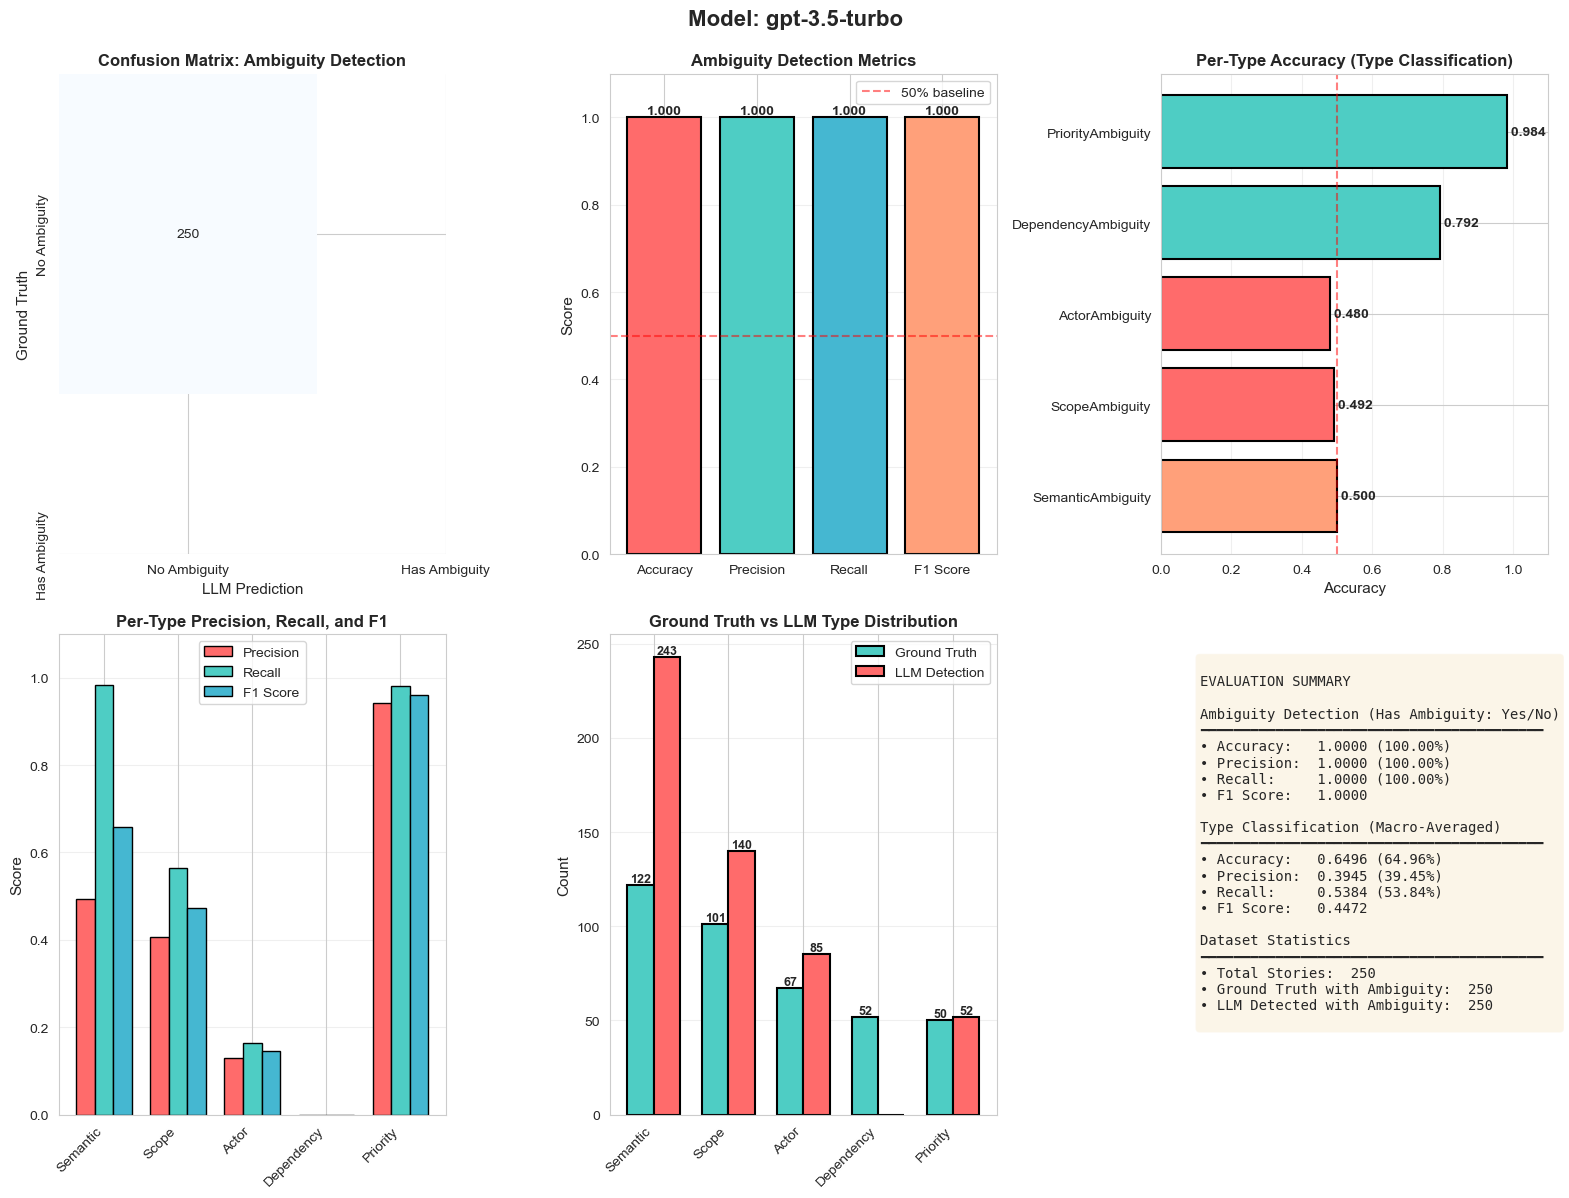

Visualization saved to 'llm_ambiguity_evaluation_results_deepseek-chat.png'


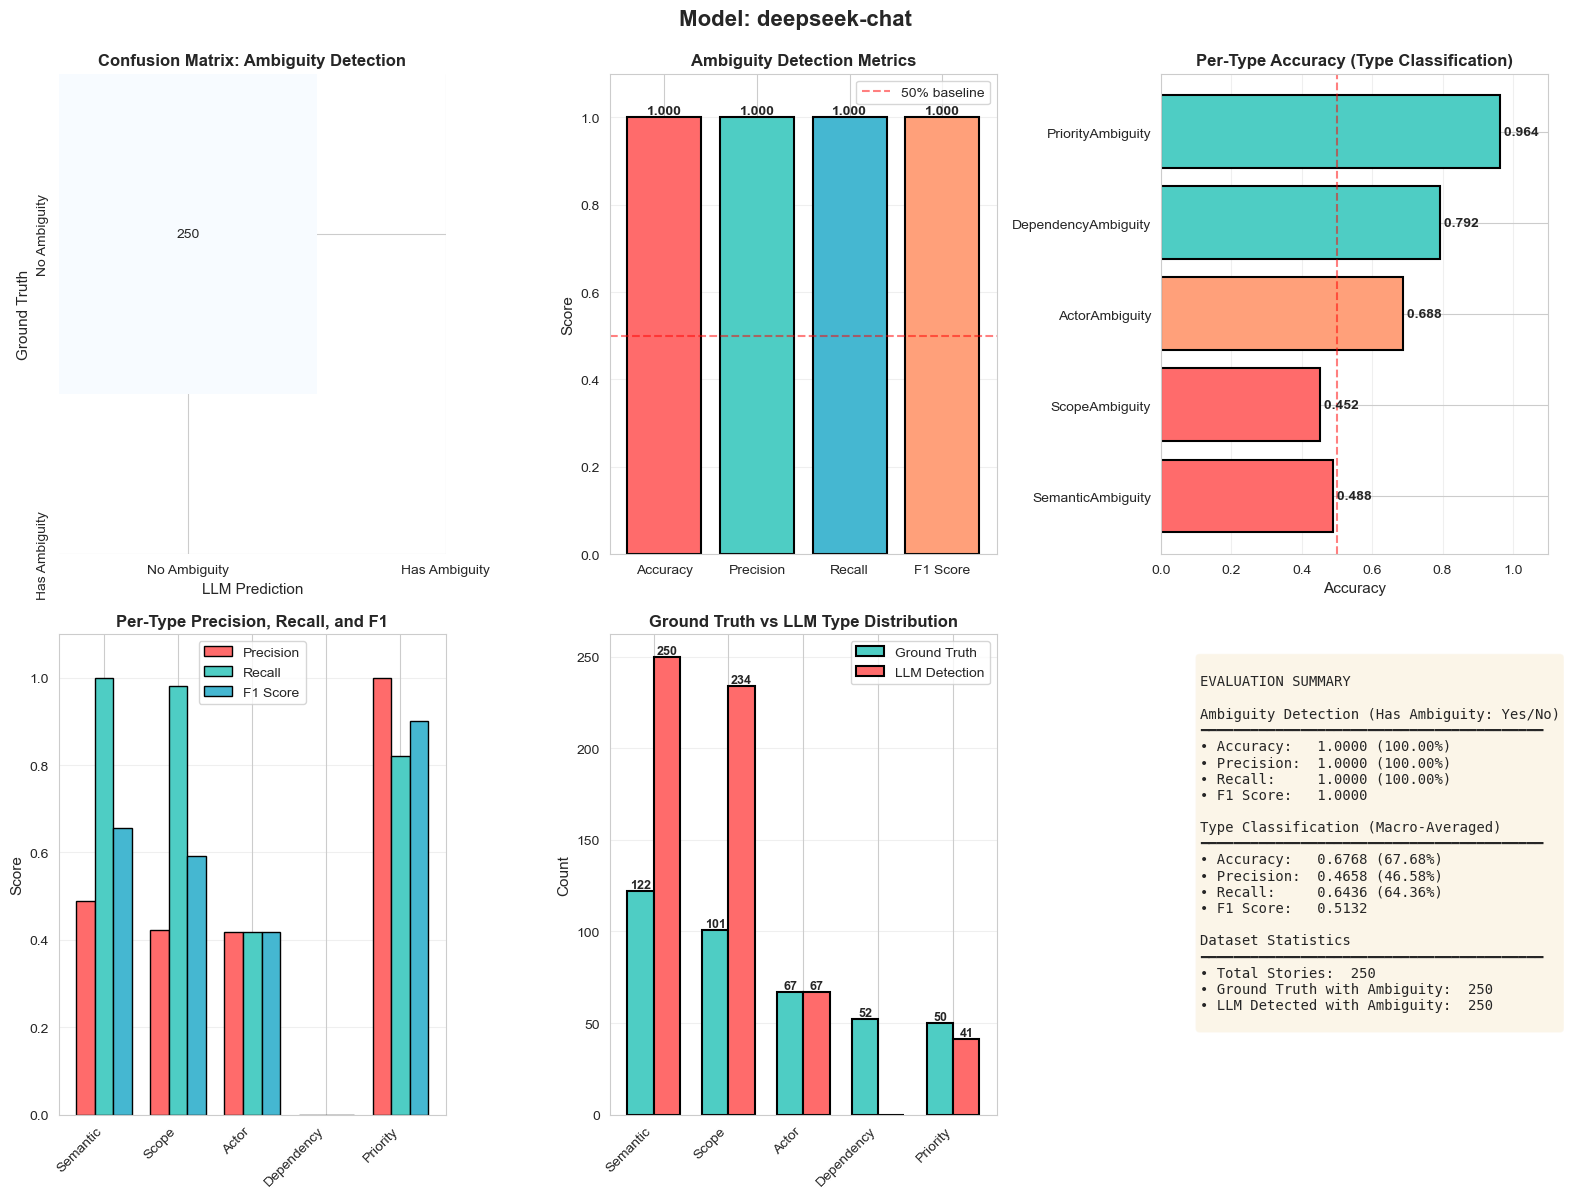


VISUALIZATION COMPLETE


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Create separate visualizations for each model
for model_idx, model in enumerate(MODELS):
    model_data = results_df[results_df['Model'] == model]
    model_eval = model_evaluation_results[model]
    model_type_metrics = type_metrics_all_models[model]
    
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle(f'Model: {model}', fontsize=16, fontweight='bold', y=0.995)
    
    # 1. Confusion Matrix for Ambiguity Detection
    ax1 = plt.subplot(2, 3, 1)
    cm = confusion_matrix(model_data['Ground_Truth_HasAmbiguity'], model_data['LLM_HasAmbiguity'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1,
                xticklabels=['No Ambiguity', 'Has Ambiguity'],
                yticklabels=['No Ambiguity', 'Has Ambiguity'])
    ax1.set_title('Confusion Matrix: Ambiguity Detection', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Ground Truth', fontsize=11)
    ax1.set_xlabel('LLM Prediction', fontsize=11)
    
    # 2. Metrics Comparison - Ambiguity Detection
    ax2 = plt.subplot(2, 3, 2)
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metrics_values = [model_eval['accuracy'], model_eval['precision'], model_eval['recall'], model_eval['f1']]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    bars = ax2.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
    ax2.set_ylabel('Score', fontsize=11)
    ax2.set_title('Ambiguity Detection Metrics', fontsize=12, fontweight='bold')
    ax2.set_ylim([0, 1.1])
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% baseline')
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Per-Type Accuracy Comparison
    ax3 = plt.subplot(2, 3, 3)
    type_names = list(model_type_metrics['per_type'].keys())
    type_accuracy = [model_type_metrics['per_type'][t]['accuracy'] for t in type_names]
    type_colors = ['#FF6B6B' if acc < 0.5 else '#FFA07A' if acc < 0.7 else '#4ECDC4' for acc in type_accuracy]
    bars = ax3.barh(type_names, type_accuracy, color=type_colors, edgecolor='black', linewidth=1.5)
    ax3.set_xlabel('Accuracy', fontsize=11)
    ax3.set_title('Per-Type Accuracy (Type Classification)', fontsize=12, fontweight='bold')
    ax3.set_xlim([0, 1.1])
    ax3.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
    for i, (bar, value) in enumerate(zip(bars, type_accuracy)):
        ax3.text(value, bar.get_y() + bar.get_height()/2.,
                f' {value:.3f}', va='center', fontweight='bold')
    ax3.grid(axis='x', alpha=0.3)
    
    # 4. Per-Type Precision, Recall, F1 Comparison
    ax4 = plt.subplot(2, 3, 4)
    x = np.arange(len(type_names))
    width = 0.25
    precision_values = [model_type_metrics['per_type'][t]['precision'] for t in type_names]
    recall_values = [model_type_metrics['per_type'][t]['recall'] for t in type_names]
    f1_values = [model_type_metrics['per_type'][t]['f1'] for t in type_names]
    
    bars1 = ax4.bar(x - width, precision_values, width, label='Precision', color='#FF6B6B', edgecolor='black')
    bars2 = ax4.bar(x, recall_values, width, label='Recall', color='#4ECDC4', edgecolor='black')
    bars3 = ax4.bar(x + width, f1_values, width, label='F1 Score', color='#45B7D1', edgecolor='black')
    
    ax4.set_ylabel('Score', fontsize=11)
    ax4.set_title('Per-Type Precision, Recall, and F1', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels([t.replace('Ambiguity', '') for t in type_names], rotation=45, ha='right')
    ax4.legend()
    ax4.set_ylim([0, 1.1])
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Ground Truth vs LLM Detection Distribution
    ax5 = plt.subplot(2, 3, 5)
    categories = AMBIGUITY_TYPES
    ground_truth_counts = [sample_df[col].sum() for col in categories]
    llm_counts = [model_data.apply(lambda x: col in x['LLM_Types'], axis=1).sum() for col in categories]
    
    x = np.arange(len(categories))
    width = 0.35
    bars1 = ax5.bar(x - width/2, ground_truth_counts, width, label='Ground Truth', color='#4ECDC4', edgecolor='black', linewidth=1.5)
    bars2 = ax5.bar(x + width/2, llm_counts, width, label='LLM Detection', color='#FF6B6B', edgecolor='black', linewidth=1.5)
    
    ax5.set_ylabel('Count', fontsize=11)
    ax5.set_title('Ground Truth vs LLM Type Distribution', fontsize=12, fontweight='bold')
    ax5.set_xticks(x)
    ax5.set_xticklabels([t.replace('Ambiguity', '') for t in categories], rotation=45, ha='right')
    ax5.legend()
    ax5.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax5.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 6. Overall Performance Summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_text = f"""
EVALUATION SUMMARY

Ambiguity Detection (Has Ambiguity: Yes/No)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:   {model_eval['accuracy']:.4f} ({model_eval['accuracy']*100:.2f}%)
• Precision:  {model_eval['precision']:.4f} ({model_eval['precision']*100:.2f}%)
• Recall:     {model_eval['recall']:.4f} ({model_eval['recall']*100:.2f}%)
• F1 Score:   {model_eval['f1']:.4f}

Type Classification (Macro-Averaged)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Accuracy:   {model_type_metrics['macro_metrics']['accuracy']:.4f} ({model_type_metrics['macro_metrics']['accuracy']*100:.2f}%)
• Precision:  {model_type_metrics['macro_metrics']['precision']:.4f} ({model_type_metrics['macro_metrics']['precision']*100:.2f}%)
• Recall:     {model_type_metrics['macro_metrics']['recall']:.4f} ({model_type_metrics['macro_metrics']['recall']*100:.2f}%)
• F1 Score:   {model_type_metrics['macro_metrics']['f1']:.4f}

Dataset Statistics
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Total Stories:  {len(model_data)}
• Ground Truth with Ambiguity:  {model_data['Ground_Truth_HasAmbiguity'].sum()}
• LLM Detected with Ambiguity:  {model_data['LLM_HasAmbiguity'].sum()}
"""
    
    ax6.text(0.1, 0.95, summary_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    safe_model_name = model.replace('/', '-').replace(':', '')
    plt.savefig(f'llm_ambiguity_evaluation_results_{safe_model_name}.png', dpi=300, bbox_inches='tight')
    print(f"Visualization saved to 'llm_ambiguity_evaluation_results_{safe_model_name}.png'")
    plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

Model comparison visualization saved to 'llm_ambiguity_model_comparison.png'


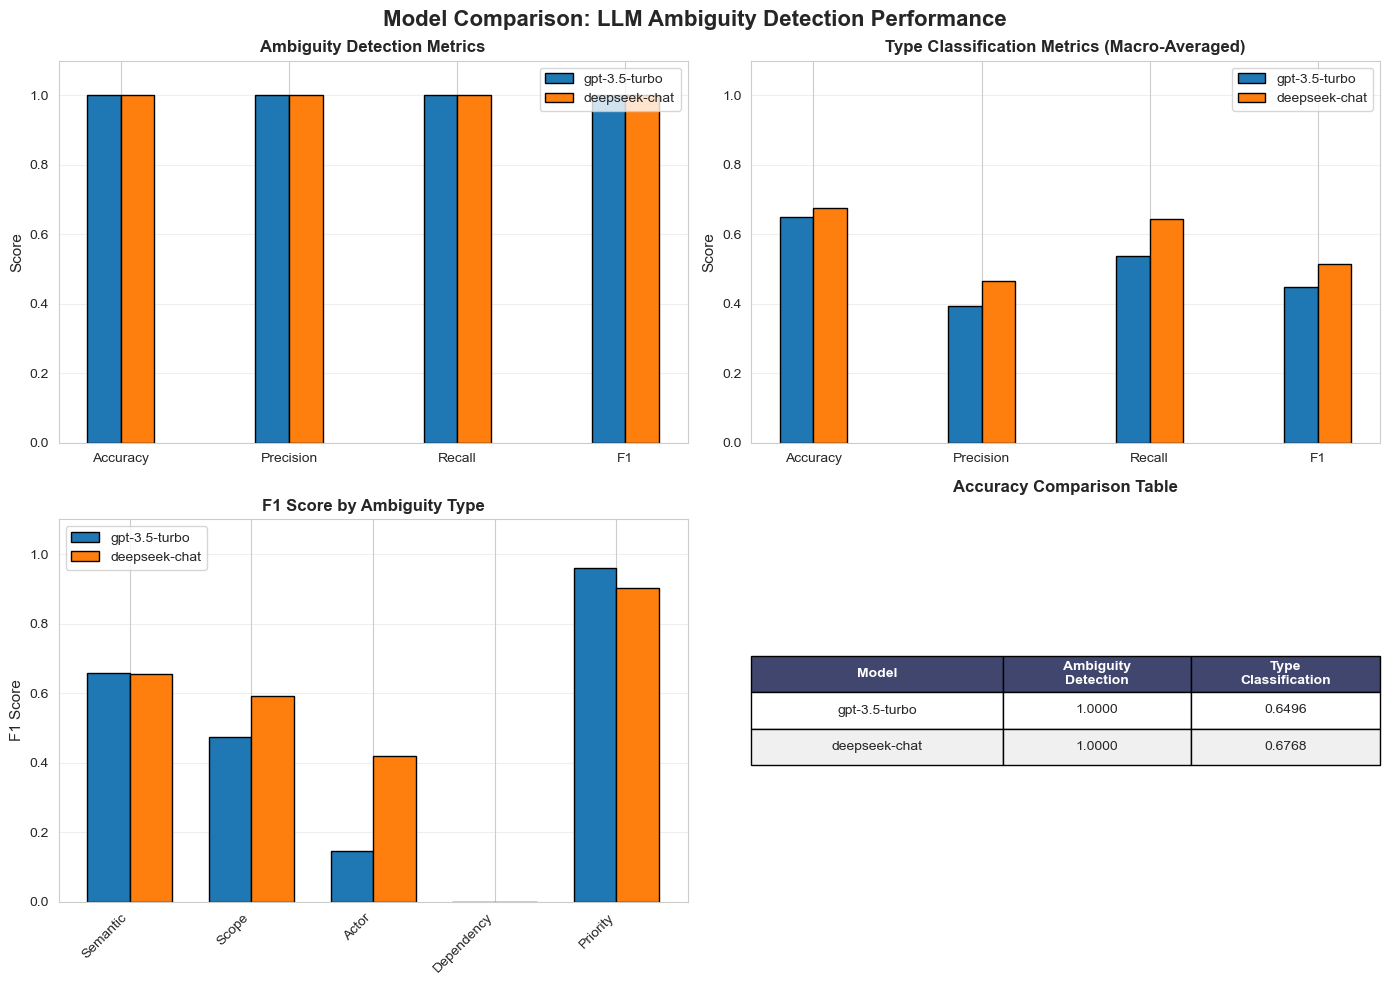


MODEL COMPARISON VISUALIZATION COMPLETE


In [32]:
## 12. Model Comparison Visualization

# Create model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Comparison: LLM Ambiguity Detection Performance', fontsize=16, fontweight='bold')

# 1. Ambiguity Detection Metrics Comparison
ax = axes[0, 0]
model_names = MODELS
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_list))
width = 0.2

for i, model in enumerate(model_names):
    metrics = model_evaluation_results[model]
    values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    ax.bar(x + i*width, values, width, label=model, edgecolor='black', linewidth=1)

ax.set_ylabel('Score', fontsize=11)
ax.set_title('Ambiguity Detection Metrics', fontsize=12, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metrics_list)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# 2. Type Classification Metrics Comparison
ax = axes[0, 1]
model_names = MODELS
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1']
x = np.arange(len(metrics_list))
width = 0.2

for i, model in enumerate(model_names):
    metrics = type_metrics_all_models[model]['macro_metrics']
    values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1']]
    ax.bar(x + i*width, values, width, label=model, edgecolor='black', linewidth=1)

ax.set_ylabel('Score', fontsize=11)
ax.set_title('Type Classification Metrics (Macro-Averaged)', fontsize=12, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels(metrics_list)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# 3. F1 Score Comparison by Type
ax = axes[1, 0]
type_names = AMBIGUITY_TYPES
x = np.arange(len(type_names))
width = 0.35

for i, model in enumerate(model_names):
    f1_values = [type_metrics_all_models[model]['per_type'][t]['f1'] for t in type_names]
    ax.bar(x + i*width, f1_values, width, label=model, edgecolor='black', linewidth=1)

ax.set_ylabel('F1 Score', fontsize=11)
ax.set_title('F1 Score by Ambiguity Type', fontsize=12, fontweight='bold')
ax.set_xticks(x + width * (len(model_names) - 1) / 2)
ax.set_xticklabels([t.replace('Ambiguity', '') for t in type_names], rotation=45, ha='right')
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# 4. Accuracy Comparison Table
ax = axes[1, 1]
ax.axis('tight')
ax.axis('off')

table_data = []
table_data.append(['Model', 'Ambiguity\nDetection', 'Type\nClassification'])

for model in model_names:
    ambig_acc = model_evaluation_results[model]['accuracy']
    type_acc = type_metrics_all_models[model]['macro_metrics']['accuracy']
    table_data.append([model, f'{ambig_acc:.4f}', f'{type_acc:.4f}'])

table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.4, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(table_data)):
    for j in range(len(table_data[0])):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('#ffffff')

ax.set_title('Accuracy Comparison Table', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('llm_ambiguity_model_comparison.png', dpi=300, bbox_inches='tight')
print("Model comparison visualization saved to 'llm_ambiguity_model_comparison.png'")
plt.show()

print("\n" + "="*80)
print("MODEL COMPARISON VISUALIZATION COMPLETE")
print("="*80)